In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-13 16:26:41.524779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 16:26:41.524805: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d-%b-%y')
df = pd.read_csv('../data_region.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

### Create batches of training data (12 months)

In [5]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [6]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=250, batch_size=32, callbacks=[callback])

    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    return model 

In [7]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    model = fit(X, y, n_steps_in, n_steps_out)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in, 1))
    pred = model.predict(x_input).reshape(-1, 1)
    pred = scaler.inverse_transform(pred)
    
    mae, rmse, smape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(actual[i:i+n_steps_in], pred, mae, rmse, smape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_steps_in, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
    
    return mae, rmse, smape

In [8]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [9]:
def measure_error(actual, pred, step, index):
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [10]:
df1 = df1.pivot_table('count', 'date', 'region')
df2 = df2.pivot_table('count', 'date', 'region')
df3 = df3.pivot_table('count', 'date', 'region')

In [11]:
regions = df1.columns.tolist()

Epoch 1/250


2022-10-13 16:26:43.396156: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-13 16:26:43.396200: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-13 16:26:43.396583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16/16 [==============================] - 1s 5ms/step - loss: 0.0884
Epoch 2/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 3/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 4/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 5/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 6/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 7/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 8/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 9/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 10/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 11/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 12/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 13/250
16/16 [=============================

16/16 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 103/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 104/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 105/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 106/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 107/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 108/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 109/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 110/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 111/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 112/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 113/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 114/250
16/16 [=========

16/16 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 203/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 204/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 205/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 206/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 207/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 208/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 209/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 210/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 211/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 212/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 213/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 214/250
16/16 [=========

16/16 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 52/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 53/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 54/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 55/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 56/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 57/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 58/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 59/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 60/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 61/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 62/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 63/250
16/16 [=====================

16/16 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 152/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 153/250
16/16 [==============================] - 0s 11ms/step - loss: 0.0114
Epoch 154/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 155/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 156/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 157/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 158/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 159/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 160/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 161/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 162/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 163/250
16/16 [========

16/16 [==============================] - 1s 6ms/step - loss: 0.1675
Epoch 2/250
16/16 [==============================] - 0s 7ms/step - loss: 0.1175
Epoch 3/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0535
Epoch 4/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 5/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0158
Epoch 6/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0150
Epoch 7/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 8/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 9/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 10/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 11/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 12/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 13/250
16/16 [=============================

16/16 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 103/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 104/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 105/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 106/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 107/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 108/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 109/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 110/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 111/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 112/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 113/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 114/250
16/16 [=========

16/16 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 203/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 204/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 205/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 206/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 207/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 208/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 209/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 210/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 211/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 212/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 213/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 214/250
16/16 [=========

16/16 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 53/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 54/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 55/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 56/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 57/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0154
Epoch 58/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 59/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 60/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0154
Epoch 61/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0154
Epoch 62/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0154
Epoch 63/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 64/250
16/16 [=====================

16/16 [==============================] - 0s 5ms/step - loss: 0.0149
Epoch 153/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 154/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 155/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 156/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0149
Epoch 157/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 158/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 159/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0149
Epoch 160/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 161/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 162/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 163/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0149
Epoch 164/250
16/16 [=========

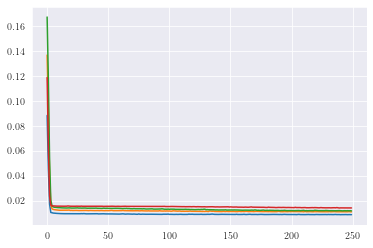

In [12]:
mae1, rmse1, smape1 = list(), list(), list()
for _ in regions:
    dataset = df1[[_]].values
    dataset = df1[[_]].astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    mae, rmse, smape = train_predict(dataset[:509], dataset[509:], df1[[_]][509:].values)
    print(_, smape)
    mae1.append(mae), rmse1.append(rmse), smape1.append(smape)

In [13]:
mae1 = np.average(mae1, axis=0).tolist()
rmse1 = np.average(rmse1, axis=0).tolist()
smape1 = np.average(smape1, axis=0).tolist()

Epoch 1/250
16/16 [==============================] - 1s 5ms/step - loss: 0.1599
Epoch 2/250
16/16 [==============================] - 0s 4ms/step - loss: 0.1114
Epoch 3/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0573
Epoch 4/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 5/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 6/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 7/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0194
Epoch 8/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0194
Epoch 9/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 10/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0190
Epoch 11/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 12/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 13/250
16/16 [=================

16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 103/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 104/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 105/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 106/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 107/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 108/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 109/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 110/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 111/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 112/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 113/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0186
Epoch 114/250
16/16 [=========

16/16 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 203/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0183
Epoch 204/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 205/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 206/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 207/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 208/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 209/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 210/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 211/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 212/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 213/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 214/250
16/16 [=========

16/16 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 52/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 53/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 54/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 55/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 56/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 57/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 58/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0167
Epoch 59/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 60/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 61/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 62/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 63/250
16/16 [=====================

16/16 [==============================] - 0s 5ms/step - loss: 0.0162
Epoch 152/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 153/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 154/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 155/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 156/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0162
Epoch 157/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 158/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 159/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 160/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0162
Epoch 161/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 162/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0162
Epoch 163/250
16/16 [=========

16/16 [==============================] - 1s 4ms/step - loss: 0.1622
Epoch 2/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0994
Epoch 3/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0382
Epoch 4/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0237
Epoch 5/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0233
Epoch 6/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0228
Epoch 7/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 8/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0226
Epoch 9/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0227
Epoch 10/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 11/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 12/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0226
Epoch 13/250
16/16 [=============================

16/16 [==============================] - 0s 5ms/step - loss: 0.0205
Epoch 103/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0207
Epoch 104/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 105/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0207
Epoch 106/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 107/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0206
Epoch 108/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0204
Epoch 109/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0205
Epoch 110/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0204
Epoch 111/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0208
Epoch 112/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0205
Epoch 113/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0205
Epoch 114/250
16/16 [=========

16/16 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 203/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 204/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 205/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 206/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 207/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 208/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0192
Epoch 209/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 210/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0192
Epoch 211/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0192
Epoch 212/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 213/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 214/250
16/16 [=========

Epoch 52/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 53/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 54/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 55/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 56/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 57/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 58/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 59/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 60/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 61/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 62/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0195
Epoch 63/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 64/250
16/16 [========

16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 153/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 154/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 155/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0186
Epoch 156/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0186
Epoch 157/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 158/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 159/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 160/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0186
Epoch 161/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 162/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 163/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0186
Epoch 164/250
16/16 [=========

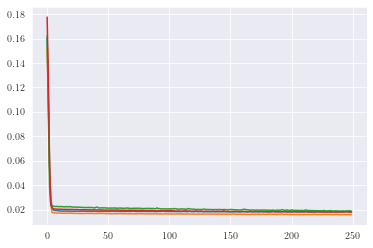

In [14]:
mae2, rmse2, smape2 = list(), list(), list()
for _ in regions:
    dataset = df2[[_]].values
    dataset = df2[[_]].astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    mae, rmse, smape = train_predict(dataset[:509], dataset[509:], df2[[_]][509:].values)
    print(_, smape)
    mae2.append(mae), rmse2.append(rmse), smape2.append(smape)

In [15]:
mae2 = np.average(mae2, axis=0).tolist()
rmse2 = np.average(rmse2, axis=0).tolist()
smape2 = np.average(smape2, axis=0).tolist()

Epoch 1/250
16/16 [==============================] - 1s 5ms/step - loss: 0.1587
Epoch 2/250
16/16 [==============================] - 0s 5ms/step - loss: 0.1168
Epoch 3/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0658
Epoch 4/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0294
Epoch 5/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 6/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 7/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 8/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 9/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 10/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 11/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0134
Epoch 12/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 13/250
16/16 [=================

16/16 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 103/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 104/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 105/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 106/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0126
Epoch 107/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 108/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 109/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 110/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 111/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 112/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 113/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 114/250
16/16 [=========

16/16 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 203/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 204/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 205/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0123
Epoch 206/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0123
Epoch 207/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 208/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 209/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 210/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 211/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 212/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 213/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 214/250
16/16 [=========

16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 52/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 53/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 54/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 55/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 56/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 57/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 58/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 59/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 60/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 61/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 62/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 63/250
16/16 [=====================

16/16 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 152/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 153/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 154/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 155/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 156/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 157/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 158/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 159/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 160/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 161/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 162/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 163/250
16/16 [=========

16/16 [==============================] - 1s 4ms/step - loss: 0.0708
Epoch 2/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0411
Epoch 3/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 4/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 5/250
16/16 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 6/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 7/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 8/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 9/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 10/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 11/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 12/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 13/250
16/16 [=============================

16/16 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 103/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 104/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 105/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 106/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 107/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 108/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 109/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 110/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 111/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 112/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 113/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 114/250
16/16 [=========

16/16 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 203/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 204/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 205/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 206/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 207/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 208/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 209/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 210/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 211/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 212/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 213/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 214/250
16/16 [=========

16/16 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 53/250
16/16 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 54/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 55/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 56/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 57/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 58/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 59/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 60/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 61/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 62/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 63/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 64/250
16/16 [=====================

16/16 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 153/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 154/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 155/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 156/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 157/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 158/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 159/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 160/250
16/16 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 161/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 162/250
16/16 [==============================] - 0s 8ms/step - loss: 0.0117
Epoch 163/250
16/16 [==============================] - 0s 7ms/step - loss: 0.0117
Epoch 164/250
16/16 [=========

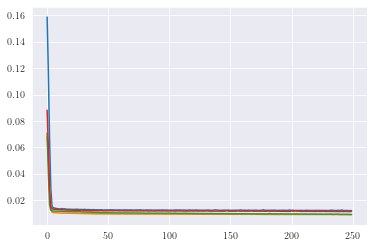

In [16]:
mae3, rmse3, smape3 = list(), list(), list()
for _ in regions:
    dataset = df3[[_]].values
    dataset = df3[[_]].astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    mae, rmse, smape = train_predict(dataset[:509], dataset[509:], df3[[_]][509:].values)
    print(_, smape)
    mae3.append(mae), rmse3.append(rmse), smape3.append(smape)

In [17]:
mae3 = np.average(mae3, axis=0).tolist()
rmse3 = np.average(rmse3, axis=0).tolist()
smape3 = np.average(smape3, axis=0).tolist()

In [18]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

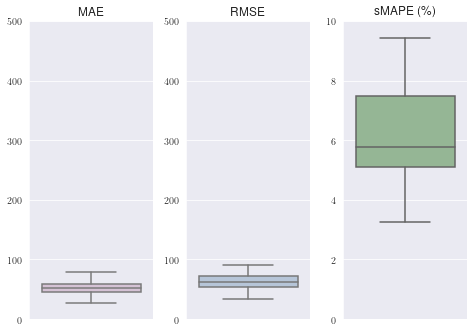

In [19]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/emergencies_lstm_daily_boxplot.pdf')

In [21]:
emer_lstm_day_region_single = [mae,rmse,smape]
%store emer_lstm_day_region_single

Stored 'emer_lstm_day_region_single' (list)
